In [3]:
! nvidia-smi

Tue Mar 26 13:26:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    91W /  70W |   1260MiB / 15079MiB |     17%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from os.path import join as pjoin
import os
from datetime import datetime
import time

In [5]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy
from fastai.vision import ShowGraph,partial
import torch

## Prepare for loging

In [6]:
import json
import re
import ipykernel
import requests
from requests.compat import urljoin
from notebook.notebookapp import list_running_servers

def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path


from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''

def notebook_save():
    Javascript(script)
    print('This notebook has been saved')



In [7]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
NB_NAME = get_notebook_name()
MODEL_NAME = NB_NAME.split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
save_folder = f"{version:0>3d}" +'.'+date
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,save_folder)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/densenet-fastai/007.26-03-2019-13-26'

In [8]:
NOTE = f"""
Note for version {version} model {MODEL_NAME}:
Train 2 times with sizes of 48 and 96 
"""
print(NOTE)


Note for version 7 model densenet-fastai:
Train 2 times with sizes of 48 and 96 



### Init data loader

In [9]:
data_path = '/home/qnkhuat/data/emotion_compilation_split_small'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=20,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=256)
       .normalize())

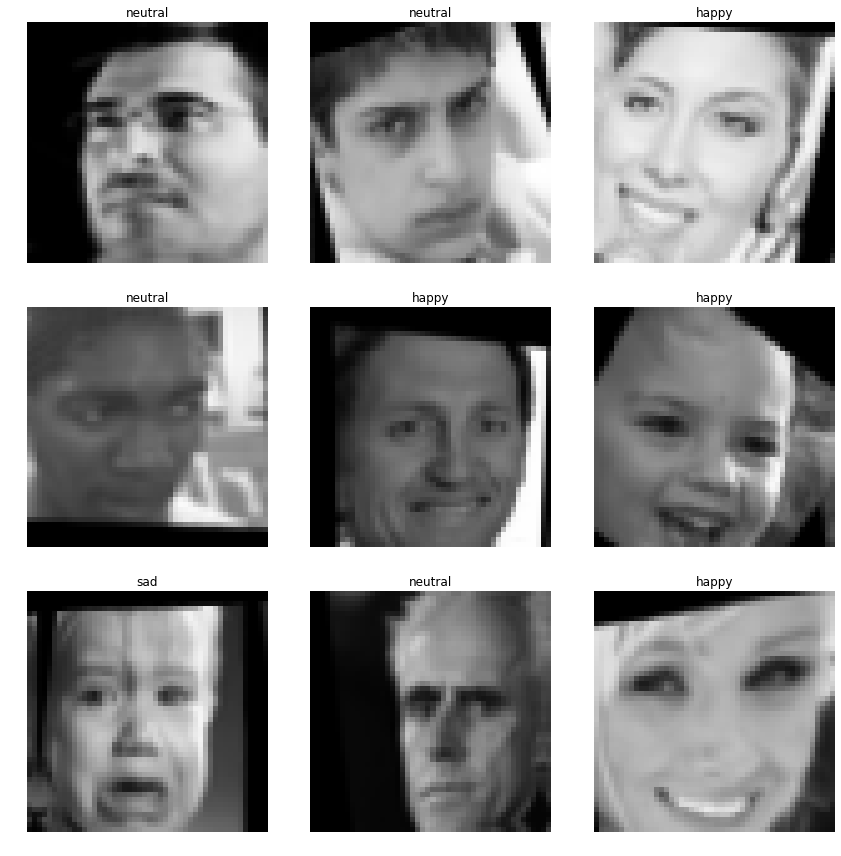

In [10]:
data.show_batch(rows=3)

## Init model

In [11]:
model = models.densenet121

In [12]:
learn = cnn_learner(data, model,callback_fns=[ShowGraph])
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)
learn.metrics = [accuracy]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


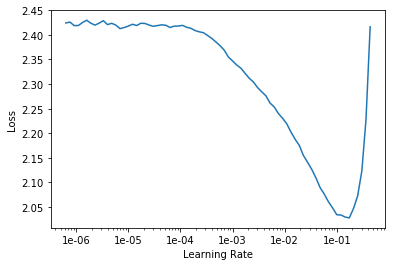

In [13]:
learn.lr_find()
learn.recorder.plot()

## Start training

In [14]:
lr=5e-2

epoch,train_loss,valid_loss,accuracy,time
0,1.521954,1.340228,0.494925,00:50
1,1.364018,1.196957,0.560615,00:46
2,1.251556,1.072602,0.620947,00:48
3,1.136253,1.016430,0.647730,00:48
4,1.072438,0.906662,0.690020,00:51
5,0.992546,0.911275,0.674796,00:49
6,0.937008,0.832120,0.707922,00:51
7,0.891164,0.805289,0.713702,00:32
8,0.832138,0.774505,0.725684,00:28
9,0.798646,0.756222,0.726952,00:26


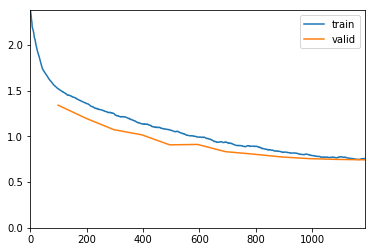

In [15]:
learn.fit_one_cycle(12,max_lr = slice(1e-4,lr))

In [15]:
learn.save('stage-1')

# Unfreeze

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


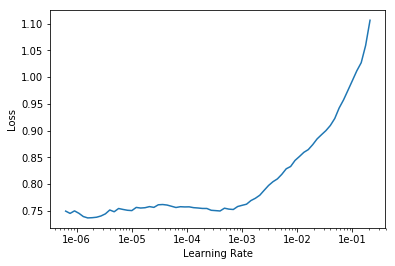

In [17]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.752269,0.648282,0.769585,00:23
1,0.658408,0.619372,0.772028,00:23
2,0.596301,0.574470,0.791577,00:23
3,0.553080,0.555806,0.796608,00:23
4,0.517190,0.568911,0.800489,00:23
5,0.485667,0.548166,0.800920,00:23
6,0.459059,0.555121,0.797470,00:23
7,0.434846,0.547912,0.809976,00:23
8,0.423073,0.557066,0.802932,00:24


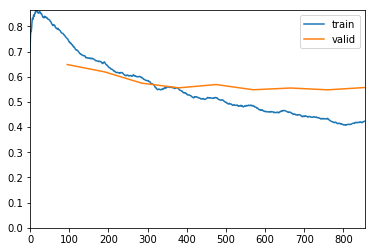

In [18]:
learn.fit(9)

In [19]:
learn.save('stage-3')

In [20]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

82.27684497833252


# Freeze

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


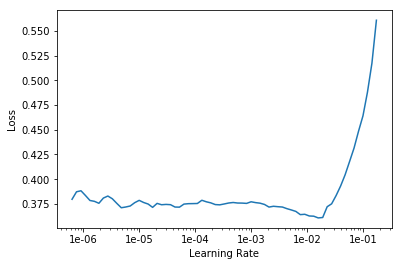

In [22]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.352159,0.518579,0.822912,00:21
1,0.340575,0.530660,0.823631,00:20
2,0.335622,0.539290,0.822481,00:20
3,0.320601,0.538882,0.823918,00:20
4,0.304526,0.544165,0.824062,00:21
5,0.292468,0.549090,0.826218,00:20
6,0.284619,0.546906,0.824781,00:20
7,0.273829,0.545101,0.825643,00:20
8,0.269118,0.544945,0.825068,00:20


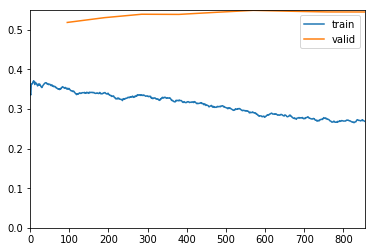

In [23]:
learn.fit_one_cycle(9,slice(1e-4,lr/5))

In [24]:
learn.save('stage-4')

In [25]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

83.29739570617676


# Train with bigger images

In [26]:
data_path = '/home/qnkhuat/data/emotion_compilation_split'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=20,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=96,ds_tfms=tfms,bs=256)
       .normalize())

In [27]:
learn.data = data

In [28]:
learn.save('stage-5')

In [29]:
# initial

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


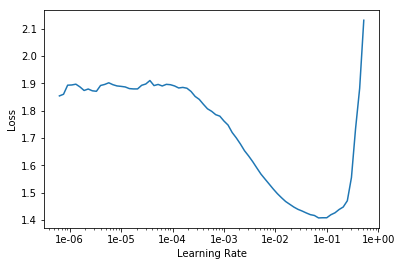

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 5e-3

epoch,train_loss,valid_loss,accuracy,time
0,1.244038,0.866040,0.690815,00:45
1,0.855962,0.673489,0.761535,00:45
2,0.672254,0.585034,0.791002,00:45
3,0.578330,0.543823,0.805663,00:44
4,0.528297,0.530799,0.807532,00:45
5,0.490870,0.501221,0.820900,00:44
6,0.466284,0.497366,0.826218,00:45
7,0.455346,0.492998,0.823918,00:44
8,0.453440,0.491009,0.824350,00:45


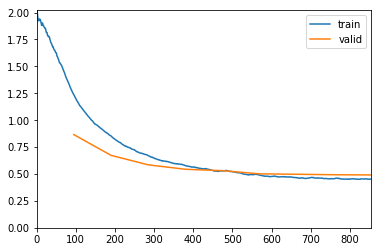

In [32]:
learn.fit_one_cycle(9,slice(lr))

In [33]:
learn.save('stage-6')

# unfreeze

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


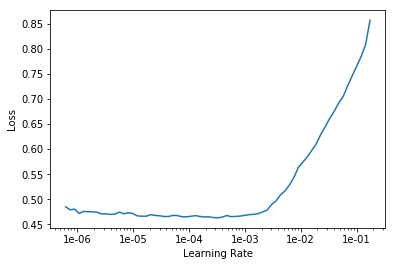

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
lr = 1e-5

fit_one_cycle barely works here

epoch,train_loss,valid_loss,accuracy,time
0,0.444136,0.491670,0.823487,00:57
1,0.451525,0.489627,0.824350,00:57
2,0.445004,0.488030,0.824637,00:57
3,0.446708,0.488067,0.824493,00:57
4,0.444926,0.487416,0.824925,00:57
5,0.440887,0.486451,0.825787,00:57


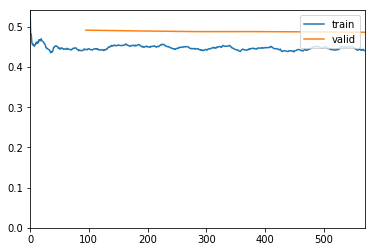

In [37]:
learn.fit(6,slice(lr))

In [38]:
learn.load('stage-6')

Learner(data=ImageDataBunch;

Train: LabelList (24336 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Valid: LabelList (6957 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Test: LabelList (3479 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: /home/qnkhuat/data/emotion_compilation_split, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d

# Refreeze

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


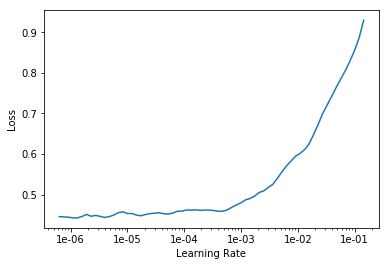

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.446454,0.490938,0.823343,00:44
1,0.456502,0.492014,0.822912,00:45
2,0.456569,0.490686,0.825212,00:45
3,0.448338,0.490184,0.823918,00:45
4,0.451483,0.490730,0.825212,00:44
5,0.447513,0.490630,0.824637,00:44
6,0.452927,0.490591,0.822912,00:44
7,0.449802,0.489023,0.824062,00:44
8,0.449338,0.490137,0.824206,00:45
9,0.448545,0.488980,0.824206,00:45


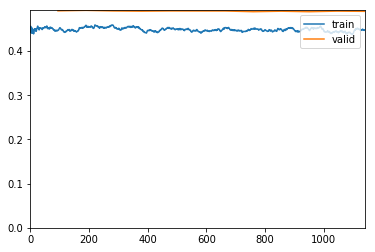

In [41]:
learn.fit_one_cycle(12,slice(5e-6,1e-4))

In [42]:
learn.save('stage-7')

In [43]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

82.24809765815735


In [44]:
learn.load('stage-6')

Learner(data=ImageDataBunch;

Train: LabelList (24336 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Valid: LabelList (6957 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Test: LabelList (3479 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: EmptyLabelList
,,,,
Path: /home/qnkhuat/data/emotion_compilation_split, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d

In [45]:
tta = accuracy(*learn.TTA()).item()*100
print(tta)

81.91749453544617


# Remember to save the checkpoint before run this

In [46]:
notebook_save()
time.sleep(3) # to save the checkpoint
nb_name = model_save_dir+'_acc_'+str(tta)[:4]+'.html'
os.system(f"jupyter nbconvert {NB_NAME} --output {nb_name}")

content = f'{version} - {str(tta)[:4]}'
with open(f'{pjoin(TRAIN_LOG_DIR,MODEL_NAME)}/{NB_NAME}.txt','a') as f :
    f.write(content)
    f.writelines(NOTE)

This notebook has been saved
